Inspecting and Explaining Models
===

Author: Nathan A. Mahynski

Date: 2023/09/12

Description: How can we inspect models and explain their predictions?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/model_inspection.ipynb)

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [1]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import shap
import imblearn

import numpy as np
import pandas as pd
import seaborn as sns

from pychemauth.classifier.plsda import PLSDA
from pychemauth.classifier.simca import SIMCA_Authenticator
from pychemauth.preprocessing.feature_selection import CollinearFeatureSelector

from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import partial_dependence, permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import train_test_split, LearningCurveDisplay, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy     : 1.24.3
pychemauth: 0.0.0b4
matplotlib: 3.7.2
imblearn  : 0.11.0
seaborn   : 0.12.2
watermark : 2.4.3
shap      : 0.45.1
pandas    : 1.5.3
sklearn   : 1.3.0



<h3>Load the Data</h3>

In [4]:
from sklearn.datasets import load_wine as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [5]:
# Here we have 3 different classes of wine
np.unique(y)

array([0, 1, 2])

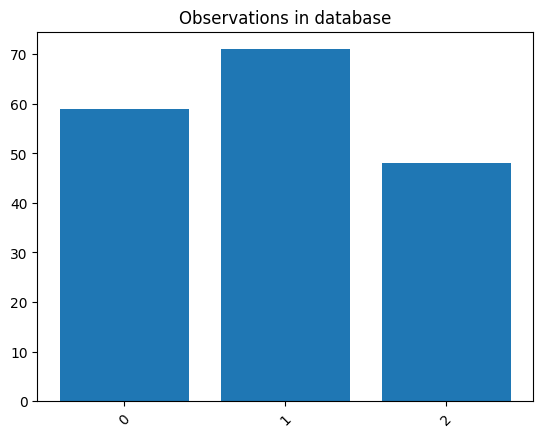

In [6]:
plt.bar(
    x=np.unique(y),
    height=[np.sum(y == class_) for class_ in np.unique(y)]
)
plt.xticks([0, 1, 2])
plt.title('Observations in database')
_ = plt.xticks(rotation=45)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, # Let's try to predict the salary based on the other numerical features.
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

Model Performance
---
Conventional classifiers can be characterized by a number of [metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics); however, because of their ability to predict that a sample is "None" of the known classes, authenticators often use different metrics to score their performance.  As a baseline, let's consider the performance of a Hard PLS-DA model which functions like a conventional classifier.

In [8]:
hard_plsda = PLSDA(
    n_components=2,
    alpha=0.05,
    gamma=0.01,
    not_assigned=-1,
    style='hard',
    scale_x=True,
    score_metric='TEFF'
)

_ = hard_plsda.fit(X_train, y_train)

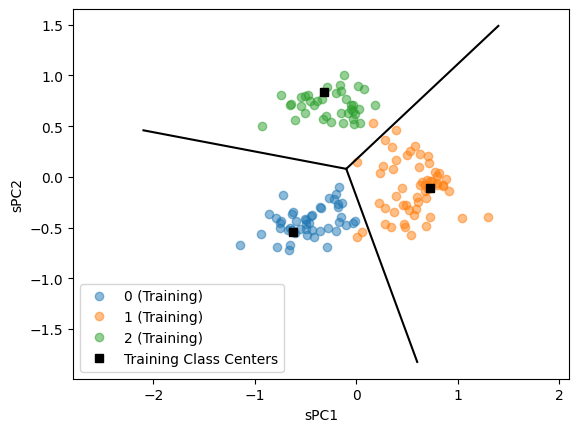

In [9]:
_ = hard_plsda.visualize(styles=['hard'])

In [10]:
# The data frame from FOM is essentially a confusion matrix, but includes as extra column for unknowns.
# For Hard PLS-DA the last column is never populated
fom = hard_plsda.figures_of_merit(hard_plsda.predict(X_test), y_test)

In [11]:
# For hard models, TEFF = TSNS = TSPS = accuracy.  This is NOT true for soft models (authenticators in general).
acc = np.sum(hard_plsda.predict(X_test) == y_test) / len(y_test)

print(
    '%.3f'%acc,
    '%.3f'%fom['TSNS'],
    '%.3f'%fom['TSPS'],
    '%.3f'%fom['TEFF']
)

1.000 1.000 1.000 1.000


In [12]:
fom['CM']

,0,1,2,-1
0,12,0,0,0
1,0,14,0,0
2,0,0,10,0


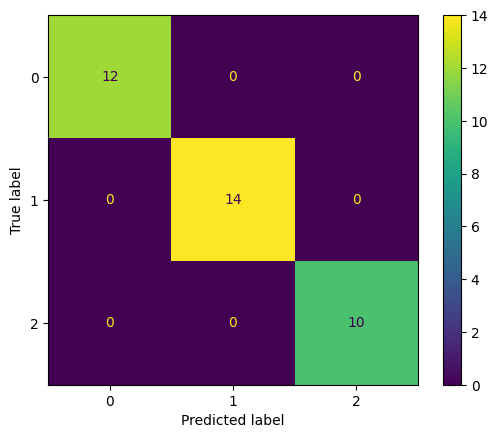

In [13]:
# For Soft PLS-DA we cannot compute a conventional confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(hard_plsda, X_test, y_test)

Model Agnostic Global Explanation  Methods
---

These explain the model in general terms, like how much it relies on certain features on average to make predictions.  Different models often rely on specific model characteristics to explain their behavior, such as loadings plots for PCA, however, there are methods to explain arbitrary models known as "model agnostic" methods.  This are particularly important since, in general, we may train pipelines which perform many different intermediate transformations and we need to be able to explain how this entire process works.

<h3>Permutation Feature Importance (PFI)</h3>

From [sklearn's documentation](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance):

> "Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. **The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.** This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature."

[Here](https://scikit-learn.org/stable/modules/permutation_importance.html#outline-of-the-permutation-importance-algorithm) is some pseudocode outlining the basic implementation of PFI.

In [14]:
r = permutation_importance(
    hard_plsda, # This must be a previously fitted estimator or pipeline
    X_test,
    y_test,
    n_repeats=30,  # How many times to shuffle each column - do this enough to be confident in your answer
    random_state=42 # For reproducibility
)

Recall the results from [feature selection](feature_selection.ipynb) which yielded similar results.

In [15]:
for feature_, imp_, std_, in sorted(
    zip(X.columns, r['importances_mean'], r['importances_std']), key=lambda x:x[1], reverse=True
):
    print('{} +/- {} :  {}'.format('%.4f'%imp_, '%.4f'%std_, feature_))


0.1037 +/- 0.0386 :  alcohol
0.0750 +/- 0.0314 :  proline
0.0583 +/- 0.0299 :  color_intensity
0.0463 +/- 0.0131 :  alcalinity_of_ash
0.0380 +/- 0.0263 :  hue
0.0370 +/- 0.0219 :  od280/od315_of_diluted_wines
0.0231 +/- 0.0239 :  flavanoids
0.0213 +/- 0.0185 :  nonflavanoid_phenols
0.0111 +/- 0.0184 :  ash
0.0093 +/- 0.0131 :  total_phenols
0.0065 +/- 0.0117 :  malic_acid
0.0065 +/- 0.0117 :  magnesium
0.0056 +/- 0.0111 :  proanthocyanins


PFI can be computed on the training set or held-out test set; however using a held-out test set is important since you can explicitly test to compare which features are important during training vs. when applied to unseen data. Features that are important to predictions made about the training set but not the test set might indicate the model is overfit to the training set, or that the test/train split is poor.

Note the similarity of PFI to [Boruta(SHAP)](feature_selection.ipynb) - Boruta(SHAP) computes feature importances after the model is (re-)trained with the original features plus randomized "shadow" versions of those features.  Features are kept if they are usually are more important than the randomized version of themselves.  Moreover, Boruta(SHAP) retrains the model many times to get average importances.  PFI does not re-train the model and does not use "shadow" features, but does look at the loss in model quality when a feature is essentially replaced by a "shadow" version of itself.

**Importantly,** PFI reflects the loss in model quality when a **single** feature is randomized.  However, if multiple features are correlated, the model still can access this "information" through its correlated features.  Thus, it might seem to the model that a feature is not important because when removed, the model did not get worse, since it relied on the information in other features.  Since feature randomization occurs one at a time, all of these correlated features may then be deemed unimportant and discarded.  **Therefore, it is important that  decorrelated features be used if PFI is to be trusted as a meaningful metric of their importance to a model.** This can be mitigated by performing cluster analysis to identify clusters of correlated features, then [removing all but one](feature_selection.ipynb) for the model to use.  

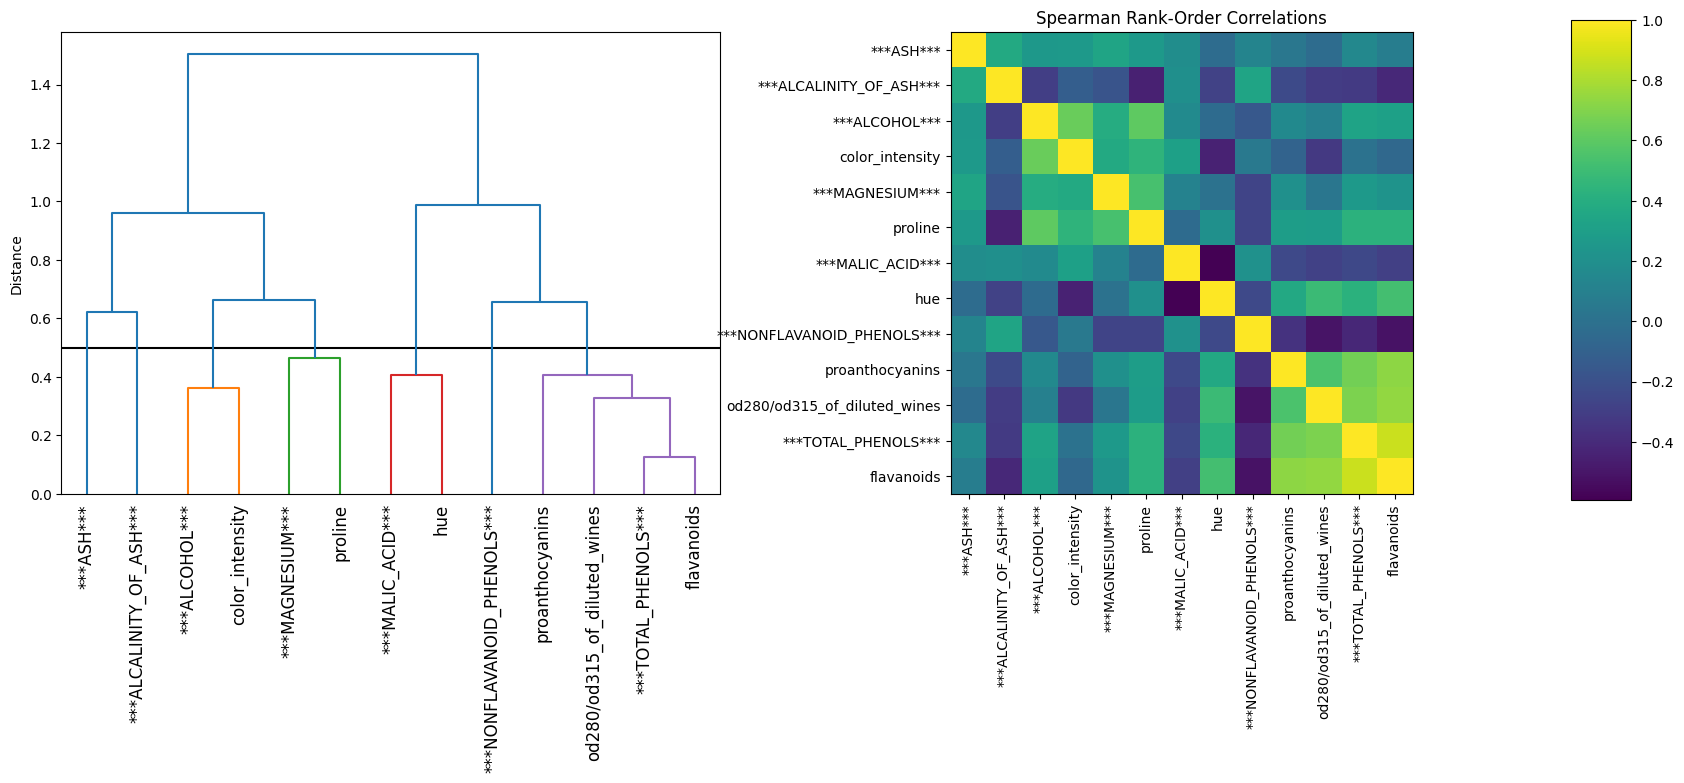

In [16]:
from pychemauth.eda.explore import InspectData

selected_features, cluster_id_to_feature_ids, _ = InspectData.cluster_collinear(
    X=X_train,
    feature_names=X.columns,
    t=0.5,
    figsize=(20,6),
    display=True # We can change this to False so we don't have these plots
)

In [17]:
selector = SelectFromModel(
    estimator=CollinearFeatureSelector(
        t=0.5,
        seed=42,
        minimize_label_entropy=False,
    ),
    threshold=0.5, # 0's are given to features ignored, 1 if they are kept so set the threshold in between
    prefit=False,
)

selector.fit(X_train)

SelectFromModel(estimator=CollinearFeatureSelector(t=0.5), threshold=0.5)

In [18]:
X.columns[selector.estimator_.get_support()]

Index(['alcohol', 'ash', 'alcalinity_of_ash', 'magnesium',
       'nonflavanoid_phenols', 'proanthocyanins', 'hue'],
      dtype='object')

In [19]:
_ = hard_plsda.fit(selector.transform(X_train), y_train)
fom = hard_plsda.figures_of_merit(
    hard_plsda.predict(selector.transform(X_test)),
    y_test
)
fom['CM'] # Very similar performance

,0,1,2,-1
0,11,1,0,0
1,0,12,2,0
2,1,0,9,0


In [20]:
r = permutation_importance(
    hard_plsda,
    selector.transform(X_test),
    y_test,
    n_repeats=30,  # How many times to shuffle each column - do this enough to be confident in your answer
    random_state=42 # For reproducibility
)

In [21]:
for feature_, imp_, std_, in sorted(
    zip(X.columns, r['importances_mean'], r['importances_std']), key=lambda x:x[1], reverse=True
):
    print('{} +/- {} :  {}'.format('%.4f'%imp_, '%.4f'%std_, feature_))

# Now, really just alcohol and flavanoids are the main features in the model

0.2426 +/- 0.0745 :  alcohol
0.1213 +/- 0.0655 :  flavanoids
0.0296 +/- 0.0405 :  total_phenols
0.0167 +/- 0.0397 :  malic_acid
0.0083 +/- 0.0330 :  ash
0.0046 +/- 0.0443 :  magnesium
0.0037 +/- 0.0224 :  alcalinity_of_ash


<h3>Partial Dependence Plots (PDP)</h3>

From [sklearn's documentation](https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence-plots):

> "Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the "complement" features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest."


Let $X_s$ be the set of input features of interest and $X_c$ be the remainder ("complement"). The partial dependence, $P$, of the response, $f$, at a point, $x_s$ is defined as:

$$P(x_s) = \int f(x_s, x_c) p(x_c) {\rm d}x_c$$

where $f(x_s, x_c)$ is the response function (such `predict`, `predict_proba` or `decision_function` methods from an estimator). Computing this integral for various values of $x_s$ produces a PDP plot. An Individual Conditional Expectation (ICE) line is defined as a single line evaluated at $x_s$. [In practice](https://scikit-learn.org/stable/modules/partial_dependence.html#computation-methods) this integral is usually computed by summation.

Because of this marginalization, the **biggest assumption is, again, that features are independent.**

* One-way PDPs tell us about the interaction between the target response and an input feature of interest (e.g. linear, non-linear). This is generally helpful for analyzing the qualitative aspects of the data that lead to a prediction.  For example, does the probability of a class rise monotonically or have interesting non-monotonic behavior; or does the probability rise or fall as a certain feature changes?

* PDPs with two input features of interest illustrate interactions between two features.

<h4>Hard PLS-DA</h4>

In [22]:
# You can compute raw partial dependence values like this.
raw = partial_dependence(
    hard_plsda,
    X=selector.transform(X_train), # Assumes independence so best to use decorrelated features
    features=[0],
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    grid_resolution=100,
    kind='average' # This gives partial dependence, 'individual' yields ICE
)

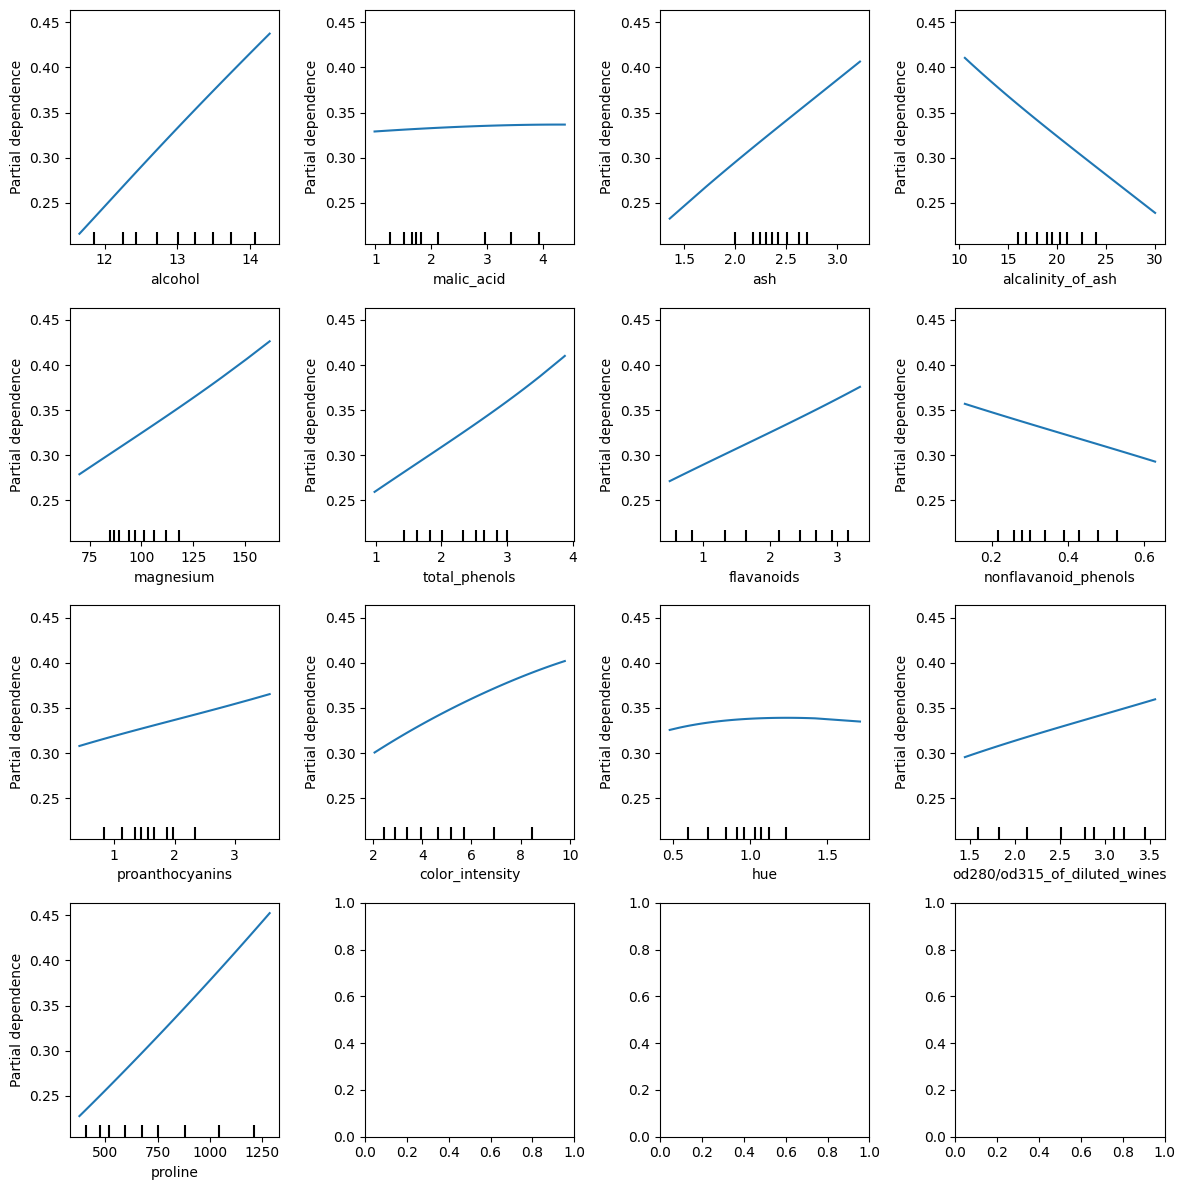

In [23]:
# However, it is generally easier to inspect them visually
model = PLSDA(
    n_components=2,
    alpha=0.05,
    gamma=0.01,
    not_assigned=-1,
    style='hard',
    scale_x=True,
    score_metric='TEFF'
)
_ = model.fit(X_train, y_train)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))
_ = PartialDependenceDisplay.from_estimator(
    model,
    X=pd.DataFrame(X_train, columns=X.columns),
    features=X.columns, # Look at PDP for each column
    target=0, # Consider class 0
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
    ax=axes.ravel()[:13]
)
plt.tight_layout()

It appears that class 0 becomes more likely as things like 'alcohol' increase and 'alcalinity_of_ash' fall.

<Axes: xlabel='y', ylabel='alcalinity_of_ash'>

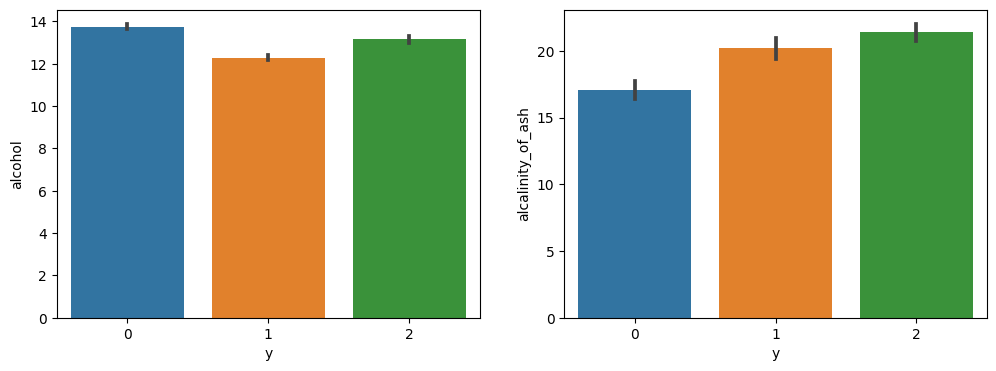

In [24]:
# Indeed, it seems class 0 has the highest alcohol on average, and the lowest alcalinity of ash so this makes sense.
X_df = X.copy()
X_df['y'] = y

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.barplot(data=X_df, x="y", y="alcohol", ax=axes[0])
sns.barplot(data=X_df, x="y", y="alcalinity_of_ash", ax=axes[1])

<h4>Soft PLS-DA</h4>

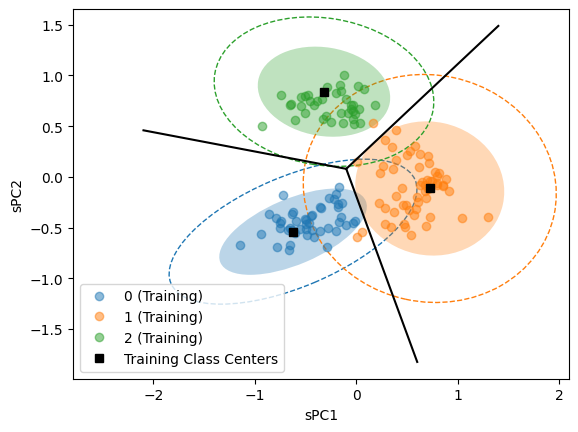

In [25]:
# Soft PLS-DA has very different boundaries, but we can still use PDPs to understand what makes the model think
# a sample belongs to class 0 (in this example)

model = PLSDA(
    n_components=2,
    alpha=0.05,
    gamma=0.01,
    not_assigned=-1,
    style='soft',
    scale_x=True,
    score_metric='TEFF'
)

_ = model.fit(X_train, y_train)

_ = model.visualize(styles=['hard', 'soft'])

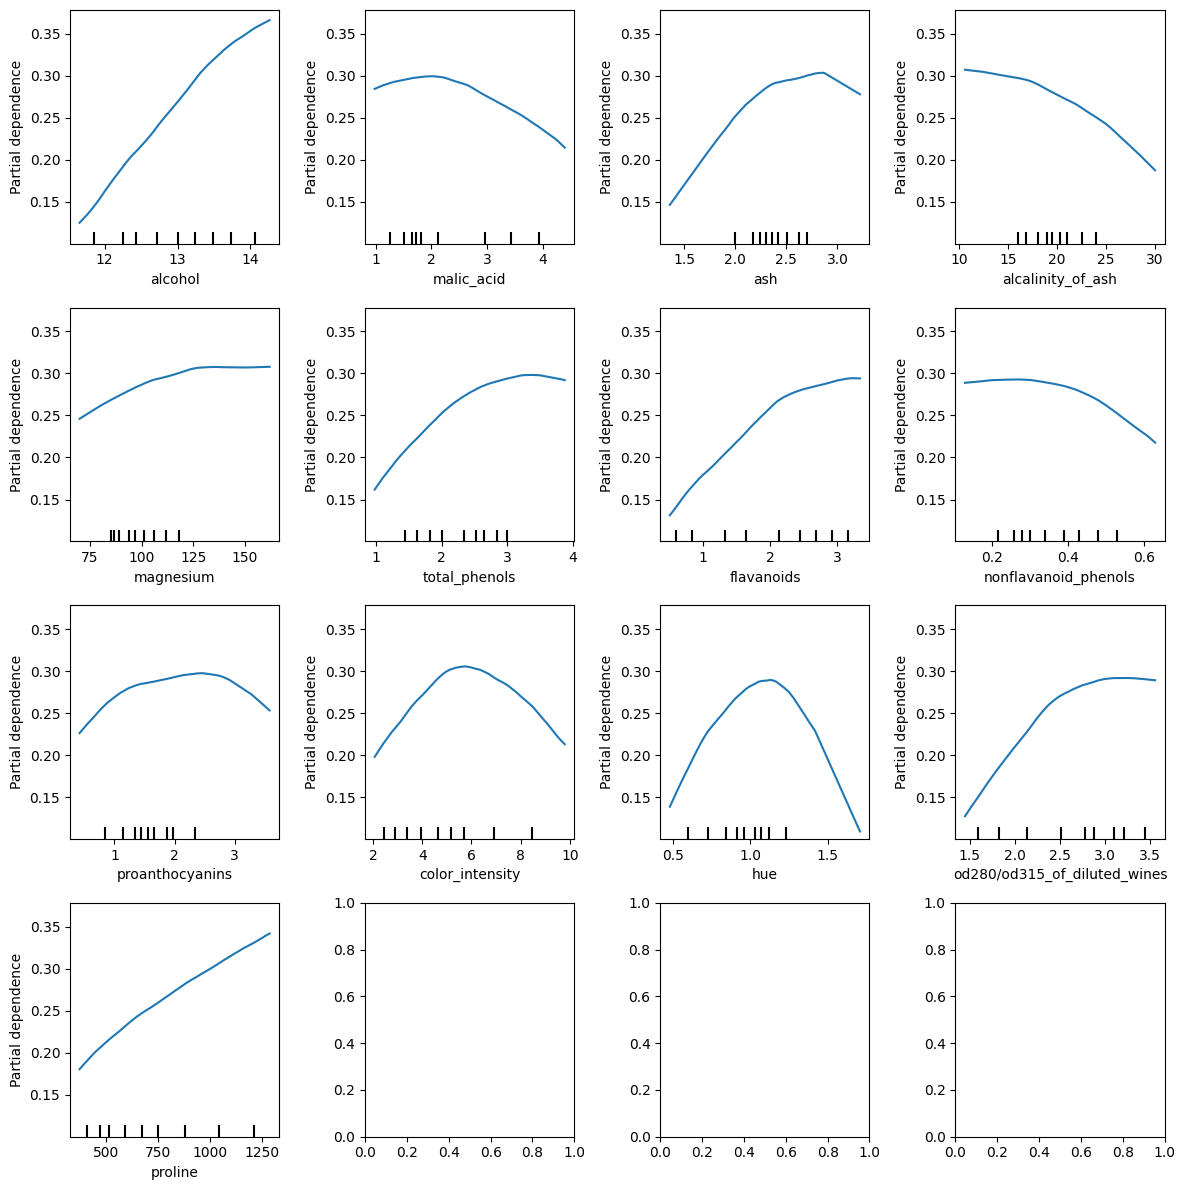

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))
_ = PartialDependenceDisplay.from_estimator(
    model,
    X=pd.DataFrame(X_train, columns=X.columns),
    features=X.columns, # Look at PDP for each column
    target=0, # Consider class 0
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
    ax=axes.ravel()[:13]
)
plt.tight_layout()

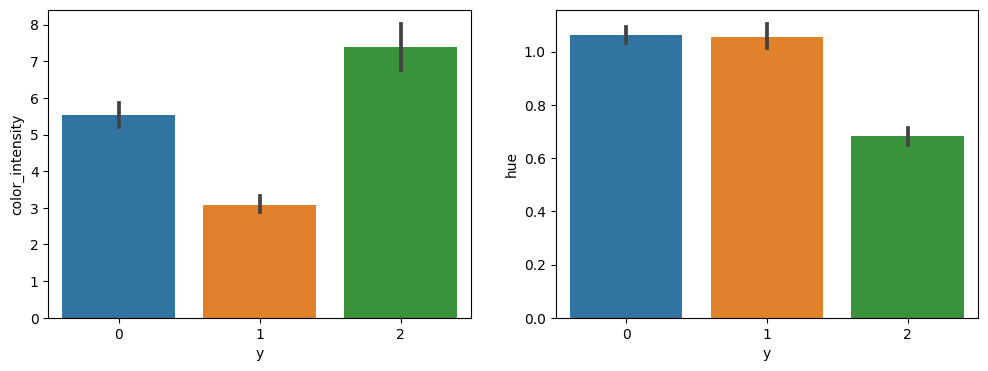

In [27]:
# Indeed, an "intermediate" value of things like hue and color_intensity seem to correspond to class 1.
# The hard model did not capture this because the hard model essentially focuses on building "walls" in between
# classes, rather than characterizing what a class "is".

X_df = X.copy()
X_df['y'] = y

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.barplot(data=X_df, x="y", y="color_intensity", ax=axes[0])
_ = sns.barplot(data=X_df, x="y", y="hue", ax=axes[1])

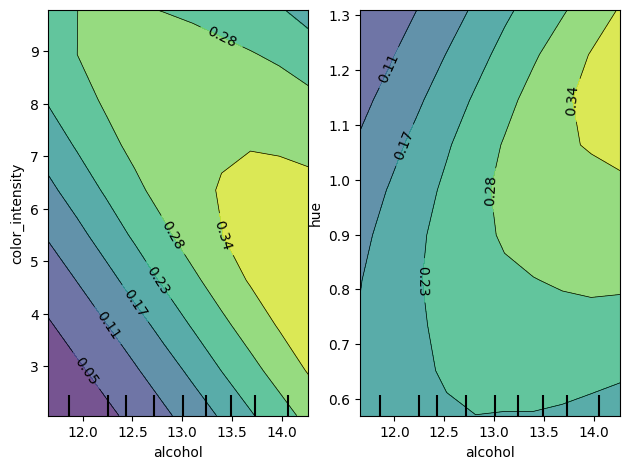

In [28]:
_ = PartialDependenceDisplay.from_estimator(
    model,
    X=pd.DataFrame(X_train, columns=X.columns),
    features=[('alcohol', 'color_intensity'), ('alcohol', 'hue')],
    target=0, # Consider class 0
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
)
plt.tight_layout()

Clearly, the soft PLS-DA model "thinks" differently given the same input.  Importantly, the above plots are reflecting the probability that a sample belongs to class 0, but the consistency with a class is based on a critical threshold cutoff.  This is not easy to directly visualize when using probabilities.  However, we can use the `decision_function` instead to analyze the model's behavior.  This returns the negative Mahalanobis distance shifted by the cutoff distance, so f < 0 implies an extreme or outlier while f > 0 implies an inlier.

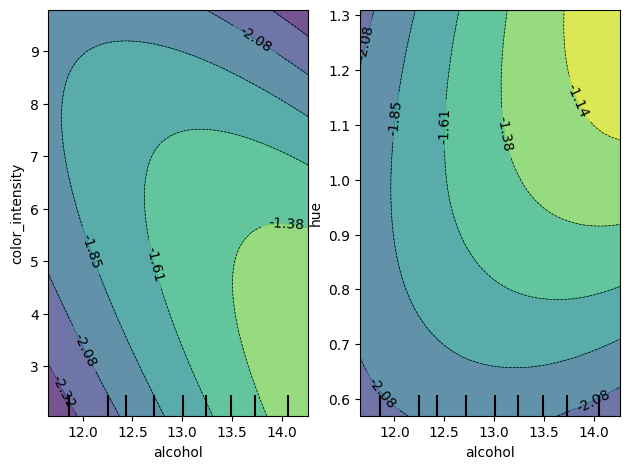

In [29]:
_ = PartialDependenceDisplay.from_estimator(
    model,
    X=pd.DataFrame(X_train, columns=X.columns),
    features=[('alcohol', 'color_intensity'), ('alcohol', 'hue')],
    target=0, # Consider class 0
    response_method='decision_function', # Use the model's decision_function() method to compute the response
    method='brute',
    grid_resolution=50,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
)
plt.tight_layout()

<h4>SIMCA</h4>

In [30]:
compliant = SIMCA_Authenticator(
    n_components=2,
    alpha=0.05,
    scale_x=True,
    style='dd-simca',
    robust="semi",
    sft=False,
    target_class=0, # Let's model class 0
    use='compliant' # Using a compliant approach will use the other classes provided at training time
)

_ = compliant.fit(X_train, y_train)

**PartialDependenceDisplay ignores the target for binary classification.  Authenticators are interpreted as binary since they predict True/False for each point being an inlier.**

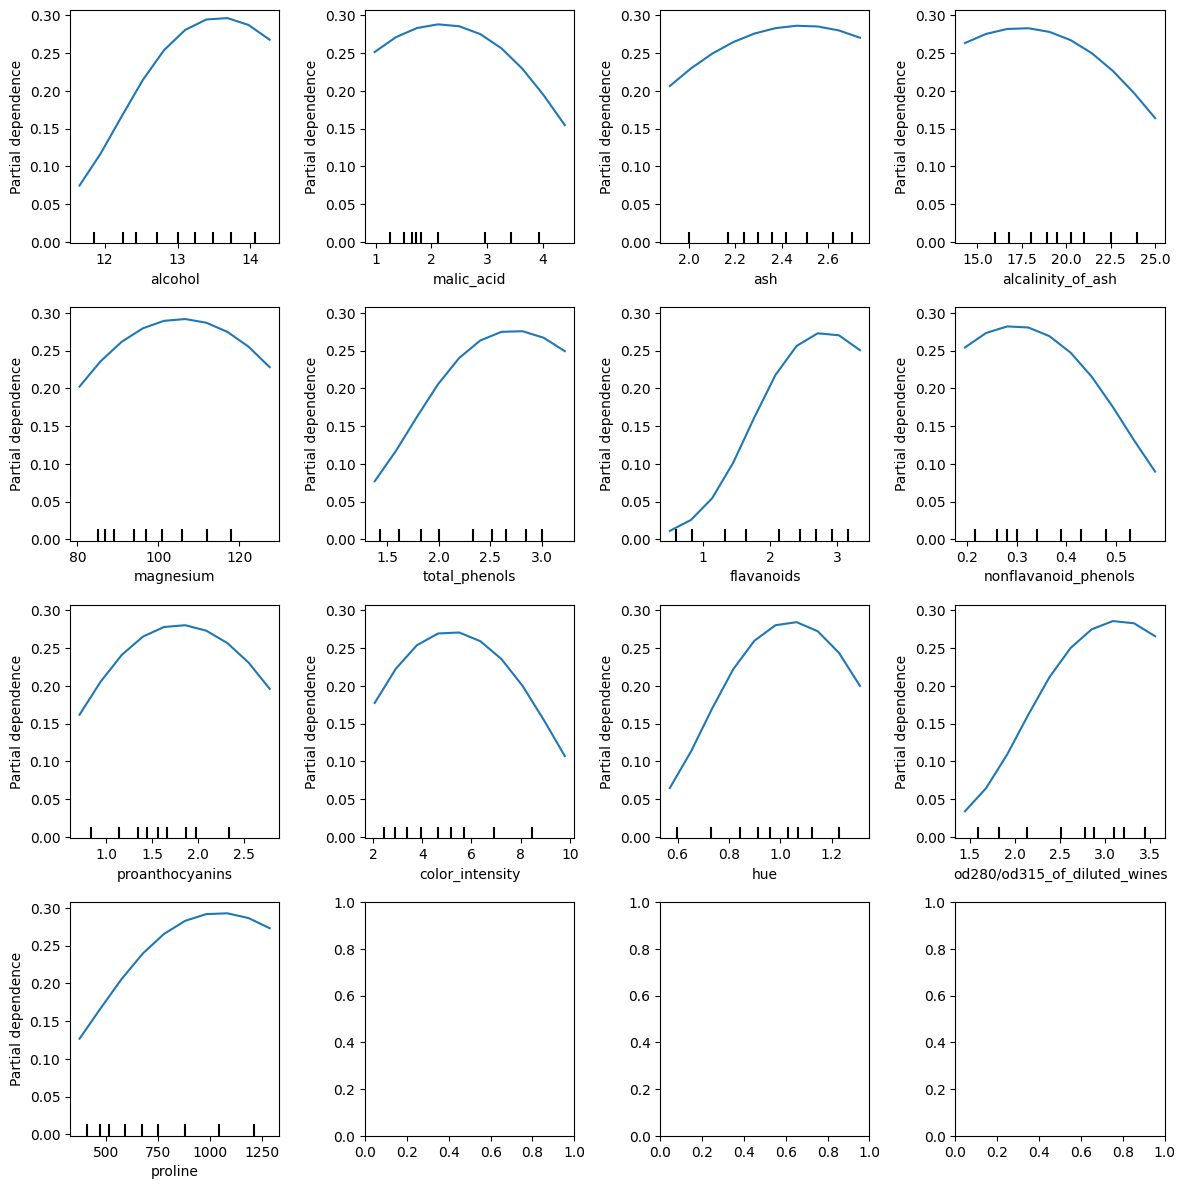

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))

_ = PartialDependenceDisplay.from_estimator(
    compliant,
    X=pd.DataFrame(X_train, columns=X.columns), # Assumes independence so best to use decorrelated features
    features=X.columns,
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
    ax=axes.ravel()[:13]
)
plt.tight_layout()

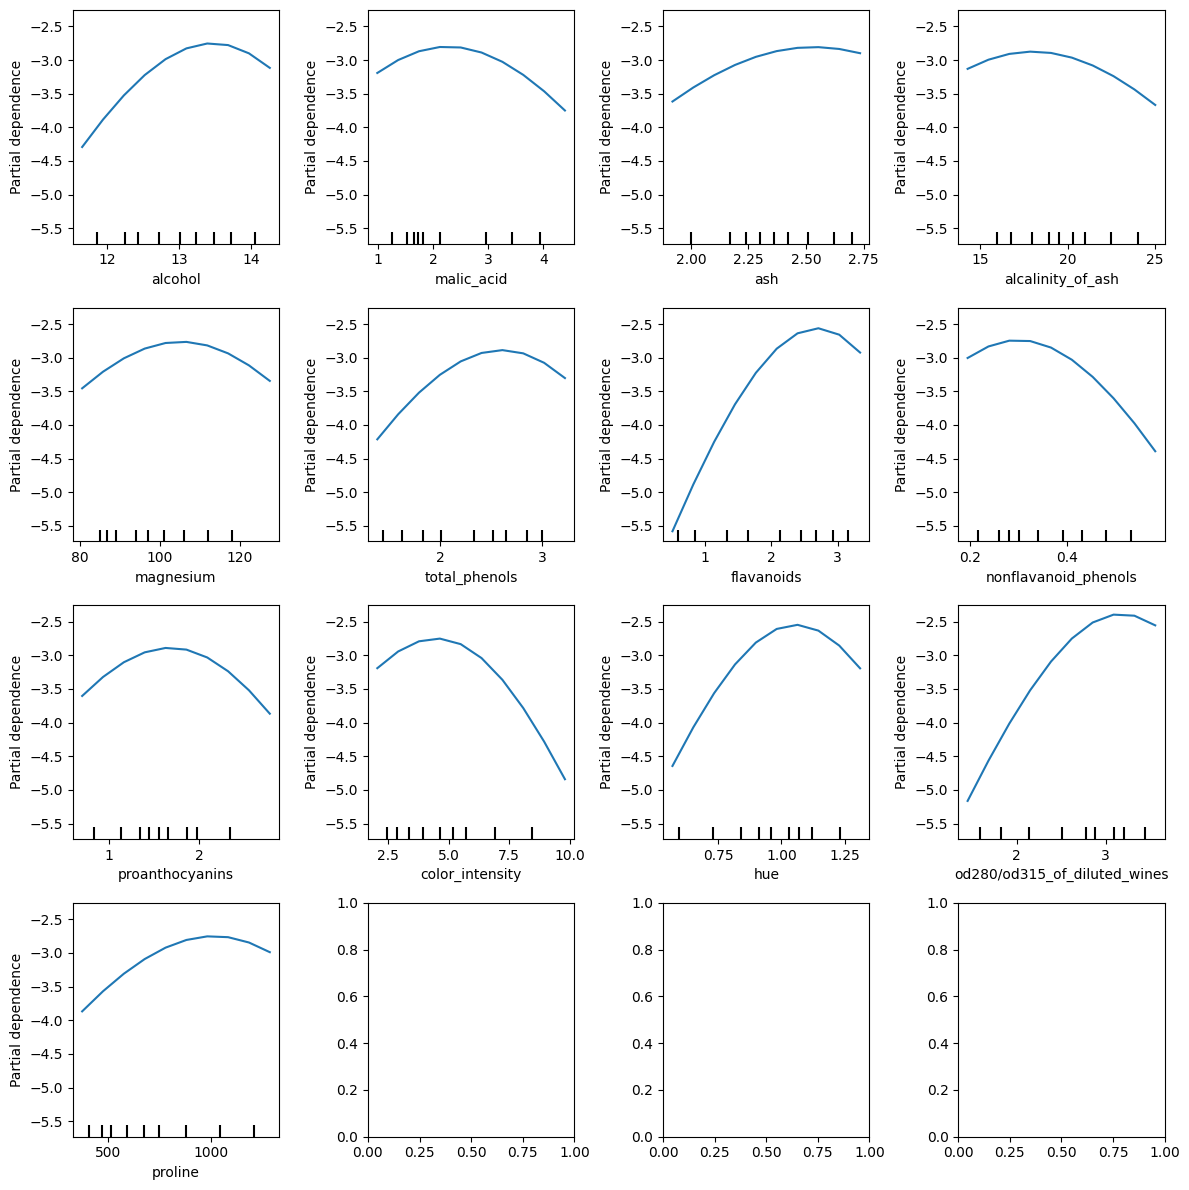

In [32]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))

_ = PartialDependenceDisplay.from_estimator(
    compliant,
    X=pd.DataFrame(X_train, columns=X.columns), # Assumes independence so best to use decorrelated features
    features=X.columns,
    response_method='decision_function', # Use the model's predict_proba() method to compute the response
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False,
    ax=axes.ravel()[:13]
)
plt.tight_layout()

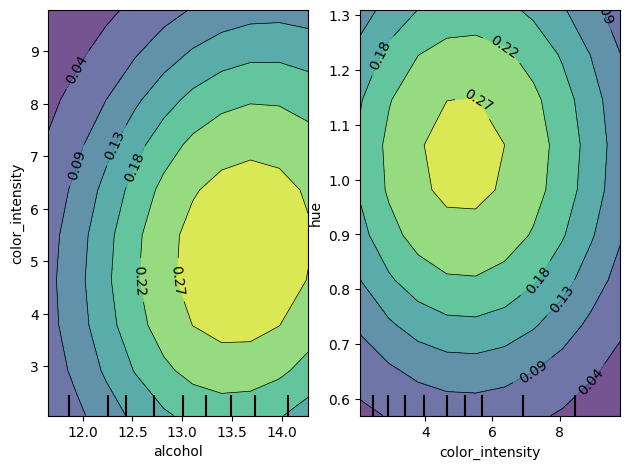

In [33]:
_ = PartialDependenceDisplay.from_estimator(
    compliant,
    X=pd.DataFrame(X_train, columns=X.columns), # Assumes independence so best to use decorrelated features
    features=[('alcohol', 'color_intensity'), ('color_intensity', 'hue')],
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False
)
plt.tight_layout()

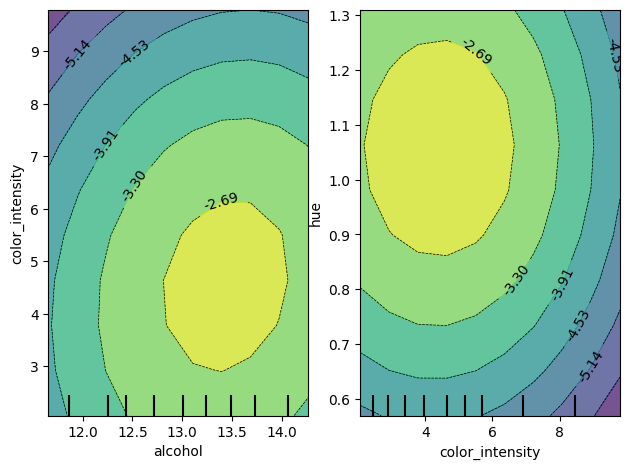

In [34]:
_ = PartialDependenceDisplay.from_estimator(
    compliant,
    X=pd.DataFrame(X_train, columns=X.columns), # Assumes independence so best to use decorrelated features
    features=[('alcohol', 'color_intensity'), ('color_intensity', 'hue')],
    response_method='decision_function',
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='average', # This gives partial dependence, 'individual' yields ICE
    random_state=0,
    centered=False
)
plt.tight_layout()
plt.show()

<h3>Shapley Additive exPlanations (SHAP)</h3>

SHAP is a tool based on cooperative game theory that can "fairly" allocate credit for a model's output to its inputs (features).  SHAP has a number of nice mathematical properties, perhaps the most salient is that the "credit" or importance assigned to each feature adds up to the model output; other methods like PFI, in general do not.  The authors of SHAP provide a nice introduction and many example to explain the methodology [here](https://shap.readthedocs.io/en/latest/overviews.html) which will not be reproduced.

> "The core idea behind Shapley value based explanations of machine learning models is to use fair allocation results from cooperative game theory to allocate credit for a model's output among its input features. In order to connect game theory with machine learning models, it is necessary to both match a model's input features with players in a game, and also match the model function with the rules of the game. Since in game theory a player can join or not join a game, we need a way for a feature to "join" or "not join" a model. The most common way to define what it means for a feature to "join" a model is to say that feature has "joined a model" when we know the value of that feature, and it has not joined a model when we don't know the value of that feature. To evaluate an existing model, $f$, when only a subset of features, $S$, are part of the model we integrate out the other features using a conditional expected value formulation."

Essentially, SHAP breaks down the difference between the model's output (let's say, the probability of belonging to a certain class) and the average probability (when you evaluate the model on some background set) into chunks given to each feature.  A positive contribution from a feature means that whatever that feature's value is, it makes the model "think" it looks more like the class being investigated.  A negative SHAP value means the model thinks that feature looks less like the class in question. The magnitude of the SHAP value can be considered a measure of importance.

In [35]:
compliant = SIMCA_Authenticator(
    n_components=2,
    alpha=0.05,
    scale_x=True,
    style='dd-simca',
    robust="semi",
    sft=False,
    target_class=0, # Let's model class 0
    use='compliant' # Using a compliant approach will use the other classes provided at training time
)

_ = compliant.fit(X_train, y_train)

In [36]:
# For many estimators you can just provide the member directly to SHAP (e.g., plsda.predict_proba) but for authenticators
# we need to write a little wrapper since we just want to "explain" the probability that a point is an inlier.
def model_proba(x):
    return compliant.predict_proba(x)[:, 1] # Extract the inlier probability

In [38]:
# The masker will handle how features "join" or "leave" a coalition.

# 1. This will assume features are independent
independent_background = shap.maskers.Independent(pd.DataFrame(X_train, columns=X.columns), max_samples=1000)

In [76]:
from pychemauth.eda.explore import InspectData
selected_features, cluster_id_to_feature_ids, _, linkage = InspectData.cluster_collinear(
    X=X_train,
    t=0.5,
    feature_names=X.columns,
    display=False,
    return_linkage=True
)

# 2. SHAP can also account for hierarchical structure in the data, akin to the heirarchical clustering used to
# decorrelate features illustrated above.
correlated_background = shap.maskers.Partition(pd.DataFrame(X_train, columns=X.columns), max_samples=1000, clustering=linkage)

In [71]:
chosen_background = correlated_background

There are a few [different model agnostic ways](https://shap.readthedocs.io/en/latest/api.html) to compute the SHAP values.

In [72]:
# 1. Exact calculation - SHAP values are NP-hard, but for datasets with ~15 features and ~100 observations we can do
# this fairly quickly
exact_explainer = shap.Explainer(model_proba, chosen_background, algorithm="exact")

# 2. This method approximates the Shapley values by iterating through permutations of the inputs.  For larger datasets
# this is much faster and more efficient.
permutation_explainer = shap.Explainer(model_proba, chosen_background, algorithm="permutation")

# 3. Partition SHAP computes Shapley values recursively through a hierarchy of features, this hierarchy defines feature
# coalitions and results in the Owen values from game theory.
# Note: you need to use `shap.maskers.Partition` with this - an error is thrown if a clustering method is not found!
partition_explainer = shap.Explainer(model_proba, chosen_background, algorithm="partition")

In [73]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)

exact_shap_values = exact_explainer(X_train_df)

In [74]:
permutation_shap_values = permutation_explainer(X_train_df)

PermutationExplainer explainer: 143it [00:12,  2.56it/s]


In [75]:
partition_shap_values = partition_explainer(X_train_df)

PartitionExplainer explainer: 143it [00:24,  3.39it/s]


In [77]:
# The "background" or base value is the average function (model_proba) evaluated over the dataset.  Since this is, by
# definition, defined by the model and the dataset, the SHAP explainer method doesn't matter.
print(
    '%.6f'%exact_shap_values.base_values[0],
    '%.6f'%partition_shap_values.base_values[0],
    '%.6f'%permutation_shap_values.base_values[0],
    '%.6f'%np.mean([model_proba([row]) for row in X_train])
)

0.272401 0.272401 0.272401 0.272401


In [78]:
exact_shap_values[0]

.values =
array([ 0.07146935,  0.02866778, -0.00238942,  0.00743009,  0.04741852,
        0.04391365,  0.07178313,  0.04334179,  0.01461577,  0.05331155,
        0.07515246,  0.04213205,  0.07382594])

.base_values =
0.2724010701188348

.data =
array([1.328e+01, 1.640e+00, 2.840e+00, 1.550e+01, 1.100e+02, 2.600e+00,
       2.680e+00, 3.400e-01, 1.360e+00, 4.600e+00, 1.090e+00, 2.780e+00,
       8.800e+02])

In [79]:
# What probability does the model predict for point 0?
p = model_proba(exact_shap_values[:1].data)
p

array([0.84307372])

In [80]:
# What is the difference from the "base" value (background average) - this is what we need to allocate "fairly".
p - exact_shap_values.base_values[0]

array([0.57067265])

In [81]:
# This is the allocation that SHAP has determined.
sum_ = np.sum(exact_shap_values.values[0])
for feature_, value_ in sorted(zip(X.columns, exact_shap_values.values[0]), key=lambda x: np.abs(x[1]), reverse=True):
    print('{} : {}'.format('%.3f'%value_, feature_))
print('---------------------\nTotal: {}'.format('%.5f'%sum_))

0.075 : hue
0.074 : proline
0.072 : flavanoids
0.071 : alcohol
0.053 : color_intensity
0.047 : magnesium
0.044 : total_phenols
0.043 : nonflavanoid_phenols
0.042 : od280/od315_of_diluted_wines
0.029 : malic_acid
0.015 : proanthocyanins
0.007 : alcalinity_of_ash
-0.002 : ash
---------------------
Total: 0.57067


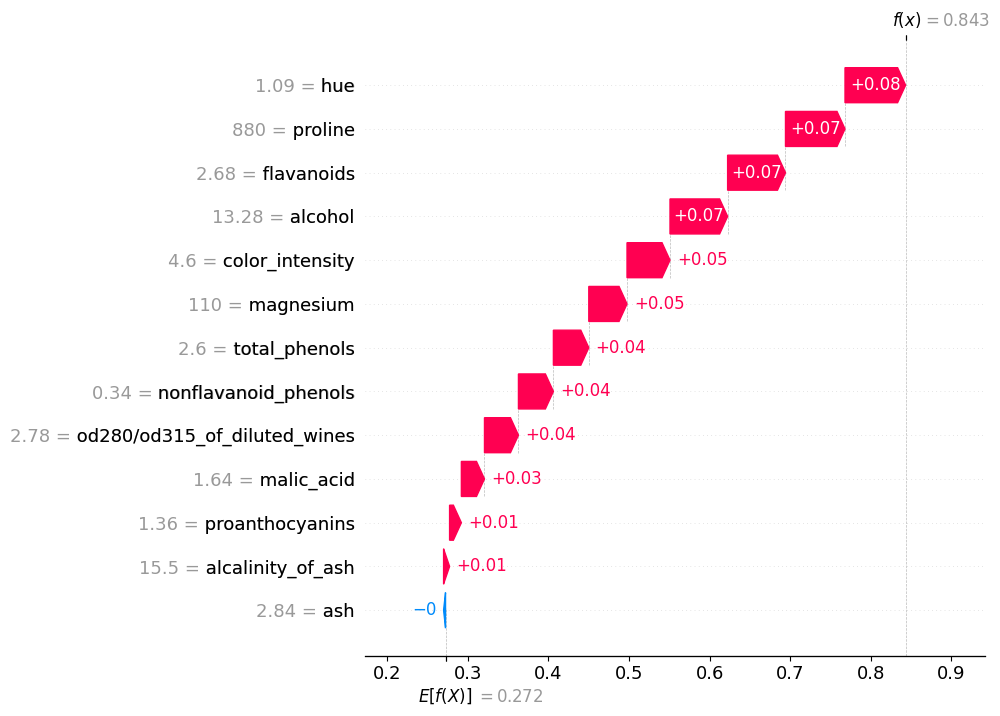

In [82]:
# SHAP has a nice way to visualize this
_ = shap.plots.waterfall(exact_shap_values[0], max_display=13, show=True)

In [94]:
# In practice there is often very little difference observed between these different
# methods for computing Shapley values on tabular datasets, though the speed
# they obtain results at can be significantly different.

idx = 0 # Examine a point in the dataset

pd.DataFrame(
    data = [["%.3f"%exact_shap_values.values[idx][i], "%.3f"%permutation_shap_values.values[idx][i], "%.3f"%partition_shap_values.values[idx][i]] for i in range(X.shape[1])],
    index = X.columns,
    columns = ['Exact', 'Permutation', 'Partition']
).T

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
Exact,0.071,0.029,-0.002,0.007,0.047,0.044,0.072,0.043,0.015,0.053,0.075,0.042,0.074
Permutation,0.072,0.029,-0.002,0.007,0.047,0.044,0.064,0.048,0.015,0.053,0.075,0.046,0.073
Partition,0.071,0.029,-0.002,0.007,0.047,0.044,0.072,0.043,0.015,0.053,0.075,0.042,0.074


In [84]:
# Partition results are very close to exact values
np.mean(np.abs(partition_shap_values.values - exact_shap_values.values))

3.741569363419945e-18

In [85]:
# As are the permutation results
np.mean(np.abs(permutation_shap_values.values - exact_shap_values.values))

0.0019047154418073342

By summing/averaging results for each individual prediction we can get a global description of how important the features are across the dataset.  Some **important observations**:

1. These results depend on the dataset used.  X_train vs. X_test will not yield identical results (usually), but if they two are truly IID then they should be very close.  You should check.  Differences could suggest a bad split ([covariate shift](https://en.wikipedia.org/wiki/Concept_drift) of the test set with respect to the training set) or model overfitting.

2. Even if you are use the paritition explainer, if the training set's data hierarchy is different from the test set you will get skewed results.

<h4>Bar Plots</h4>

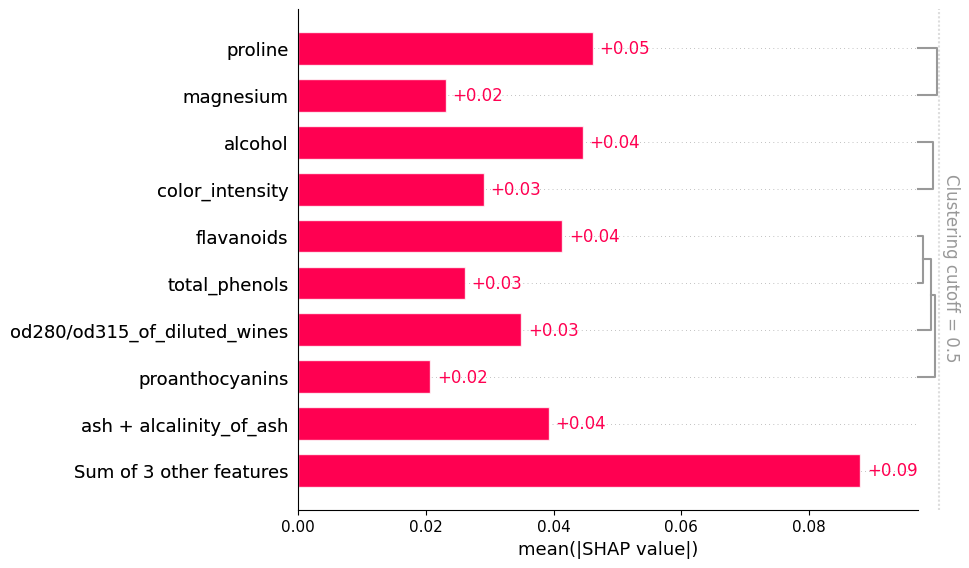

In [86]:
# By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the
# dataset given a global description of the most important features to the model (premised on the dataset).  This
# is what BorutaSHAP uses to determined feature importances.

# Hierarchical clustering can be done to help indicate some of the correlations.
shap.plots.bar(exact_shap_values, clustering=linkage, clustering_cutoff=0.5)

<h4>Heat Maps</h4>

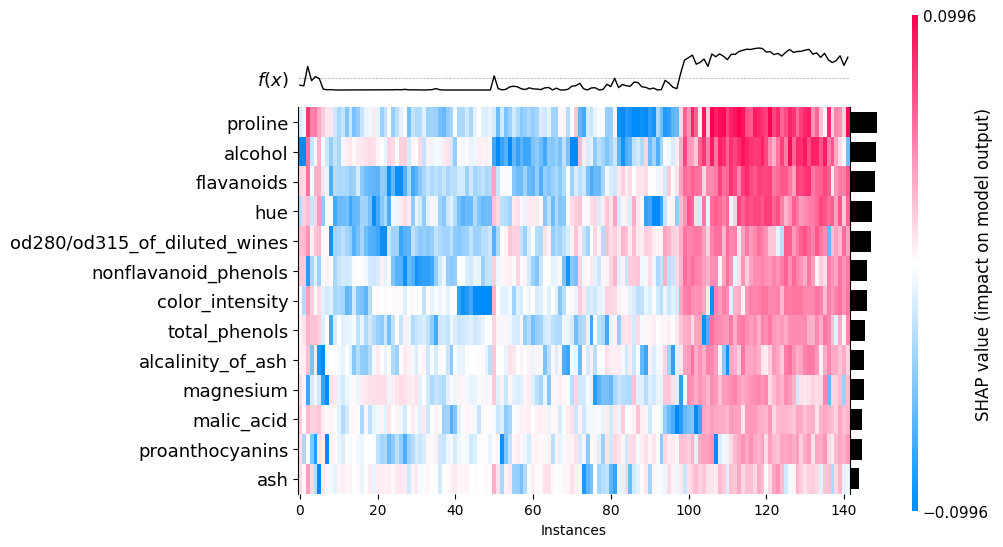

<Axes: xlabel='Instances'>

In [87]:
# This can give you a high-level summary of how each feature contributed to different predictions.
# Note that the ordering on the x-axis is NOT the original in the dataset, but have been clustered by similarity
# in their predictions.
shap.plots.heatmap(exact_shap_values, max_display=13)

<h4>Beeswarms & Violin Plots</h4>

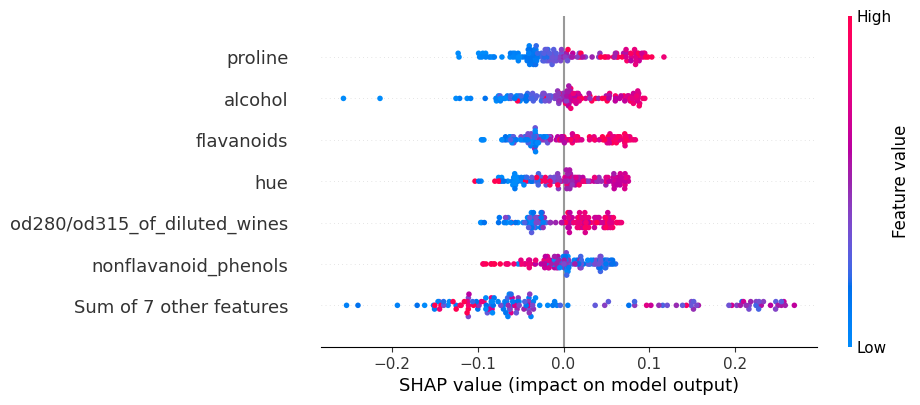

In [88]:
# This is a way to summarize all the predictions in the dataset.
shap.plots.beeswarm(exact_shap_values, max_display=7)

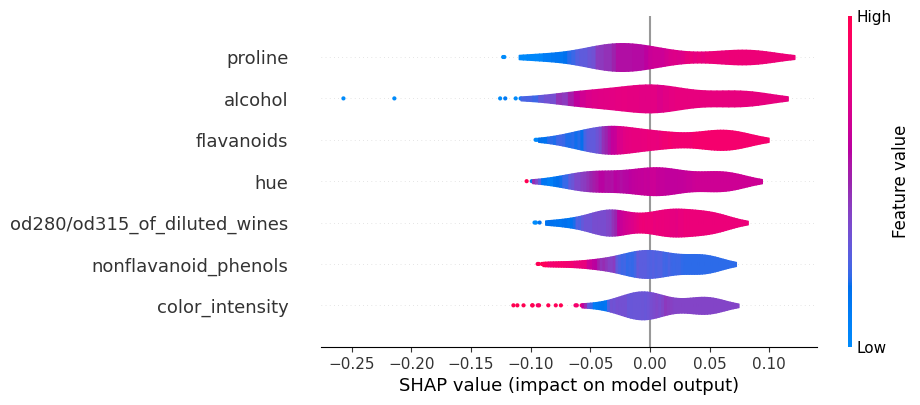

In [89]:
# A violin plot can sometimes be a little cleaner.
shap.plots.violin(exact_shap_values, max_display=7)

<h4>Scatter Plots</h4>

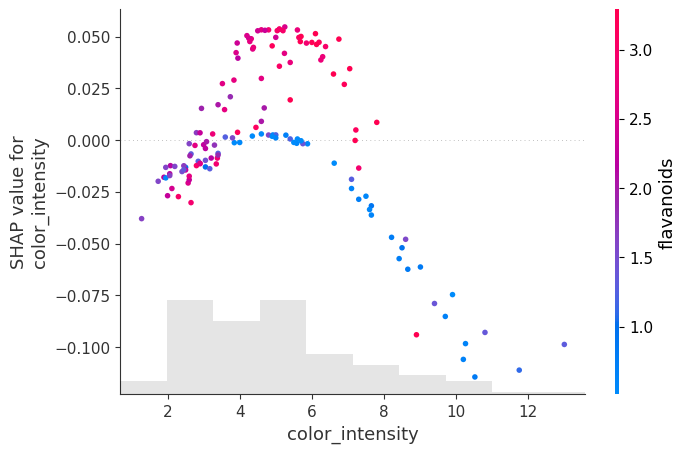

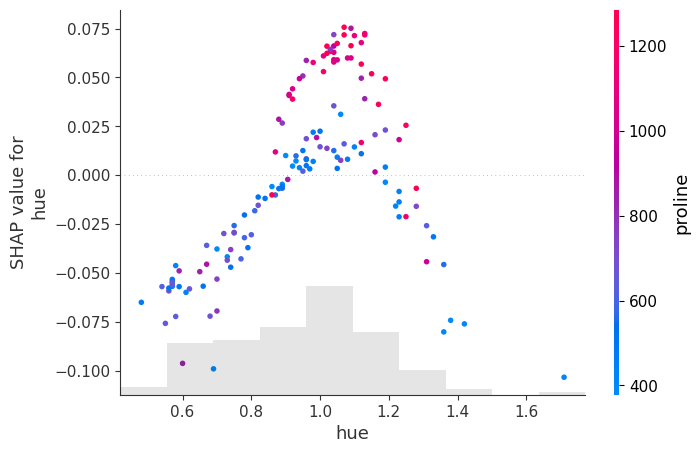

In [90]:
# Plots the value of the feature on the x-axis and the SHAP value of the same feature
# on the y-axis. This shows how the model depends on the given feature, and is like a
# richer extension of classical partial dependence plots. Vertical dispersion of the
# data points represents interaction effects.

# If `color` is an `Explanation` object, then the scatter plot points are colored by the
# feature that seems to have the strongest interaction effect with the feature given by
# the ``shap_values`` argument.  This can be helpful for teasing out correlations and
# connnections in the data.

for column in ['color_intensity', 'hue']:
    _ = shap.plots.scatter(
        exact_shap_values[:,column],
        color=exact_shap_values
    )

For intermediate color_intensity the SHAP values spike. Moreover there are appears to be 2 manifolds: one is red with high flavanoids, the other blue with low flavanoids.  At high color_intensity, the SHAP values are low and also seem to be correlated with low flavanoid levels.  You can see this is because it is not just color_intensity that determines the target class.  For comparison, refer to the PDP plots above showing a "hill" in the color_intensity-hue plane.

For the hue we observe that intermediate values have 2 "manifolds," the one with the large positive SHAP values have high proline and otherwise, negative or small SHAP values seem to be correlated with low proline levels.  

<h4>Embeddings</h4>

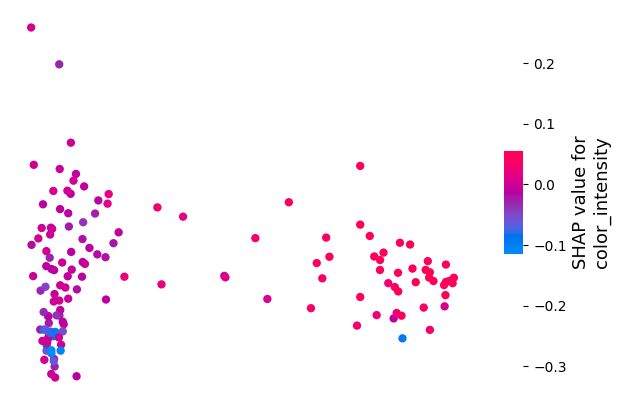

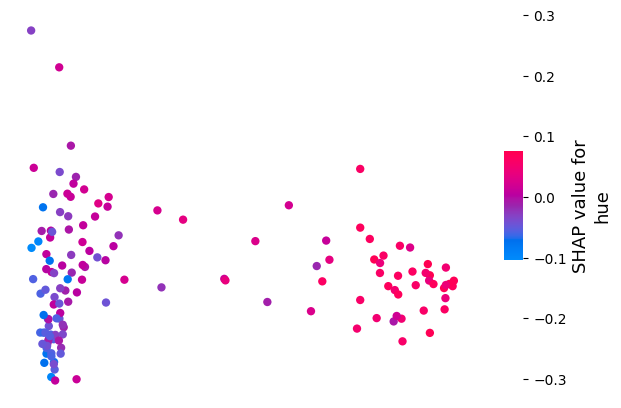

In [91]:
for feature in ['color_intensity', 'hue']:
    shap.plots.embedding(
        feature,
        exact_shap_values.values,
        feature_names=X.columns,
        method='pca',
        alpha=1.0,
        show=True
    )

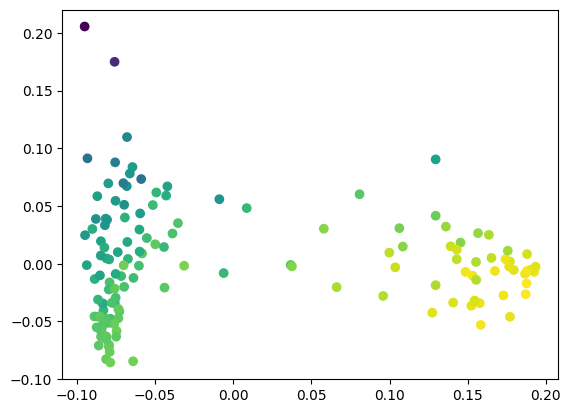

In [92]:
# This is the equivalent code - more manual, but you can also substitute any other dimensionality reduction approach,
# such as UMAP, to try to find more interesting trends.

from sklearn.decomposition import PCA
import copy

# Do a 2D projection for easy visualization
pca = PCA(n_components=2)
a = pca.fit_transform(exact_shap_values.values)

# Choose a SHAP value to color by (here, first column = 'alcohol') and normalize to [0, 1]
shap_ = copy.copy(exact_shap_values.values[:,0])
shap_ -= np.min(shap_)
shap_ /= np.max(shap_)

# Make a scatter plot
plt.scatter(a[:,0], a[:,1], c=shap_, cmap='viridis')
plt.show()

<h4>The "squashing" function</h4>

Here we have explained the **probability** that a sample belongs to a target class.  At the moment, PyChemAuth uses a logistic function applied to the `decision_function` (x-axis below) to give a "probability" (y-axis below).  Note this is not [calibrated](https://scikit-learn.org/stable/modules/calibration.html#probability-calibration).  The decision function for a SIMCA model is the distance to the threshold for acceptance as a class member.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png" style="width:400px;">

1. This means the probability has an upper bound since the origin (i.e., h = q = 0 for DD-SIMCA) can only be so far away from the boundary, while you can be infinitely far away when you are outside the acceptance boundary.

2. This logistic function "squashes" the unbounded "margin space" (raw h, q values) into a bounded domain.

From the [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Squashing%20Effect.html):
> "The value of the margin space is then in the units of information, while the values in the probability space is in the units of probability. Which space you care about can be different in different situations. The margin space is better for adding and subtracting, and directly corresponds to “evidence” in an information-theoretic sense. However, if you only care about changes in % probability, not evidence, then you would be better off using the probability space. By choosing probability space you are saying that getting lots of powerful evidence that takes you from 98% probability to 99.99% probability is not nearly as important as a smaller amount of evidence that takes you from 50% probability to 60% probability. Why does it take more evidence to go from 98% probability to 99.99% than from 50% probability to 60%? It is because in an information theoretic sense, it takes more information to go from 98% certainty to 99.99%, than it does to go from 50% certainty to 60%."

> **"Note that even though the logistic function is a monotonic transformation is can still change the ordering of which features are most important in a model. The ordering of features can change because some features may be very important for getting to 99.9% probability, while others are usually helpful in getting to 60% probability."**

In [93]:
exact_margin_explainer = shap.Explainer(
    compliant.decision_function, # Let's use the "margin" space instead of probability
    chosen_background,
    algorithm="exact"
)

exact_margin_shap_values = exact_margin_explainer(X_train_df)

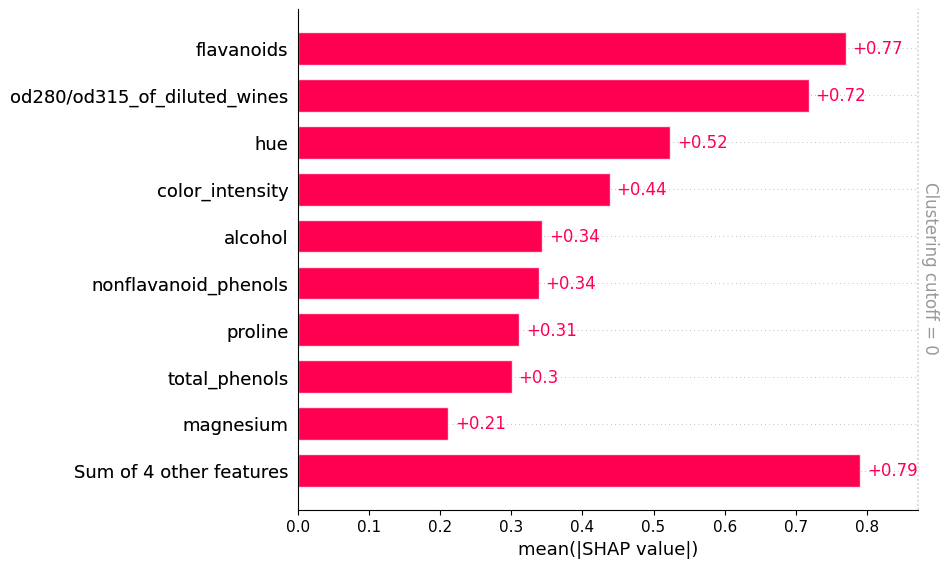

In [99]:
# Margin space explanation
shap.plots.bar(exact_margin_shap_values, clustering=linkage, clustering_cutoff=0)

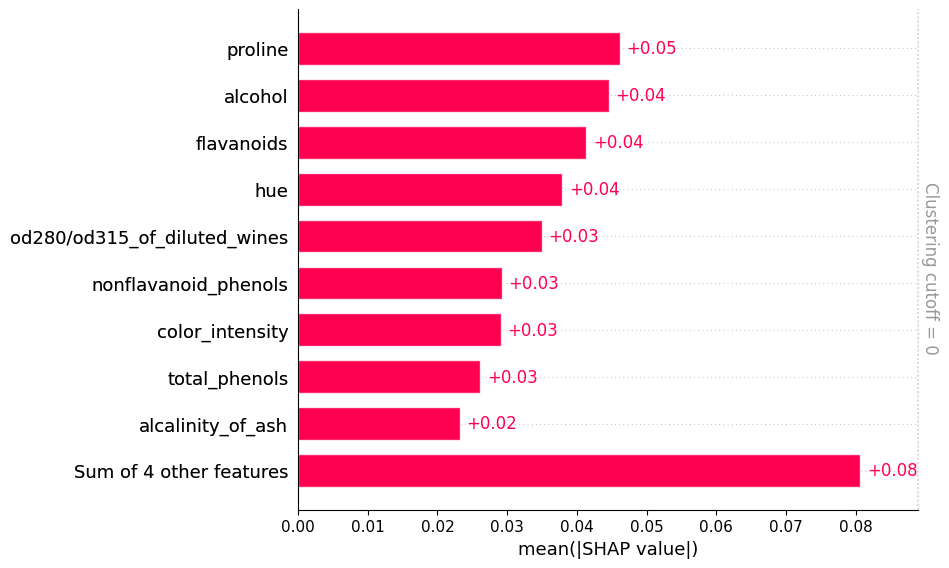

In [100]:
# Probability space explanation
shap.plots.bar(exact_shap_values, clustering=linkage, clustering_cutoff=0.0)

Local Explanation Methods
---

These help us explain a single prediction rather than the "overall" behavior of a model.  Sometimes, as with SHAP, the global explanation tools are really just a sum or average over all the individual local explanations.

<h3>Local SHAP Explanations</h3>

We can use SHAP to explain individual predictions which can be helpful to justify why a model decided something was, or was not, authentic.

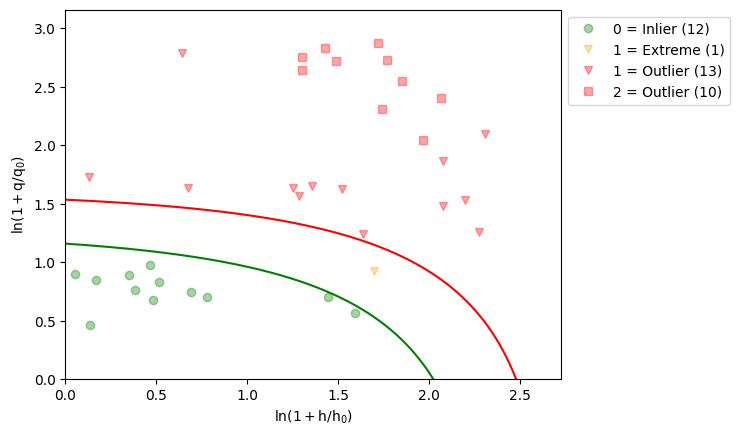

In [101]:
_ = compliant.model.visualize(X_test, y_test)

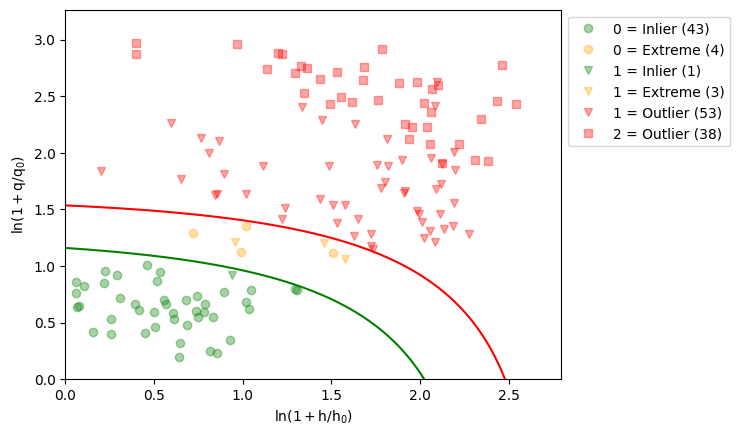

In [102]:
_ = compliant.model.visualize(X_train, y_train)

This models is very good - on the test set, things are perfect, while on the training set it misclassified 4 authentic
samples as inauthentic and accepted a single example of class 1 as an authentic sample from class 0. Let's use SHAP to explain what happened.

In [112]:
# First let's consider an explanation in probability space.
def model_proba(x):
    return compliant.predict_proba(x)[:,1] # Extract the inlier probability

X_train_df = pd.DataFrame(X_train, columns=X.columns)
background = shap.maskers.Partition(X_train_df, max_samples=1000, clustering=linkage)
explainer = shap.Explainer(model_proba, background, algorithm="exact")
shap_values = explainer(X_train_df)

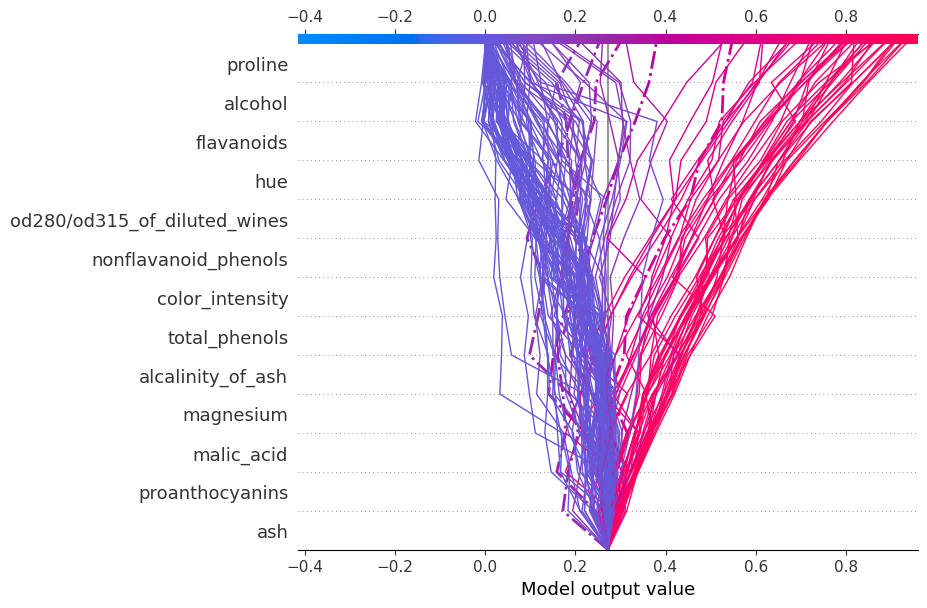

In [113]:
# Highlight the mistakes - here the mistakes look they originate in the middle of the 2 paths.
# This is to be expected.  The cutoff of acceptance as the target class is a value of 0.5
shap.plots.decision(
    shap_values.base_values[0],
    shap_values.values,
    feature_names=X.columns.tolist(),
    highlight=(compliant.predict(X_train) != (y_train == 0))
)

In [114]:
# Let's inspect the sample of class 1 it identified as class 0
fraud_index = np.where(compliant.predict(X_train) & (y_train == 1))[0][0]

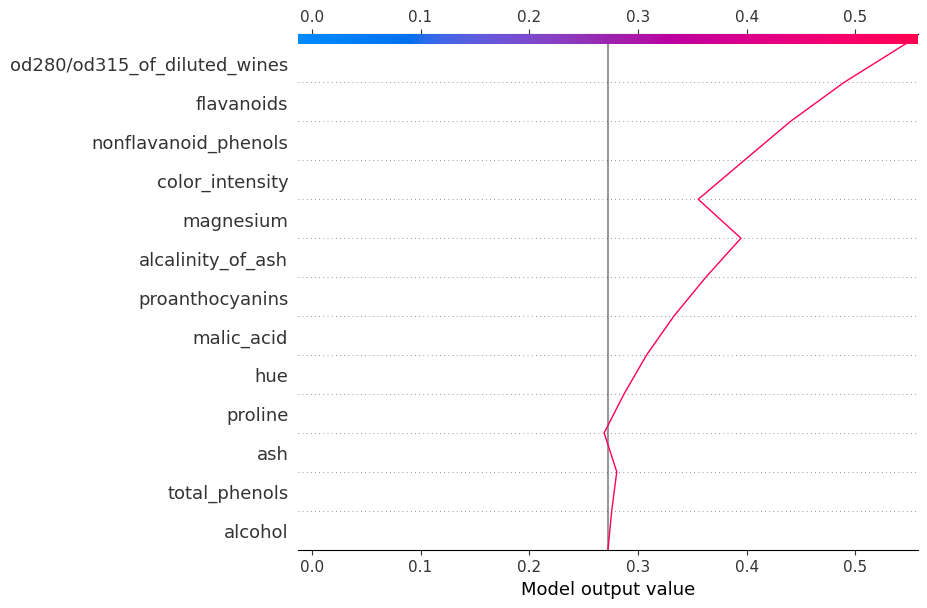

In [115]:
shap.plots.decision(
    shap_values.base_values[0],
    shap_values.values[fraud_index],
    feature_names=X.columns.tolist(),
)

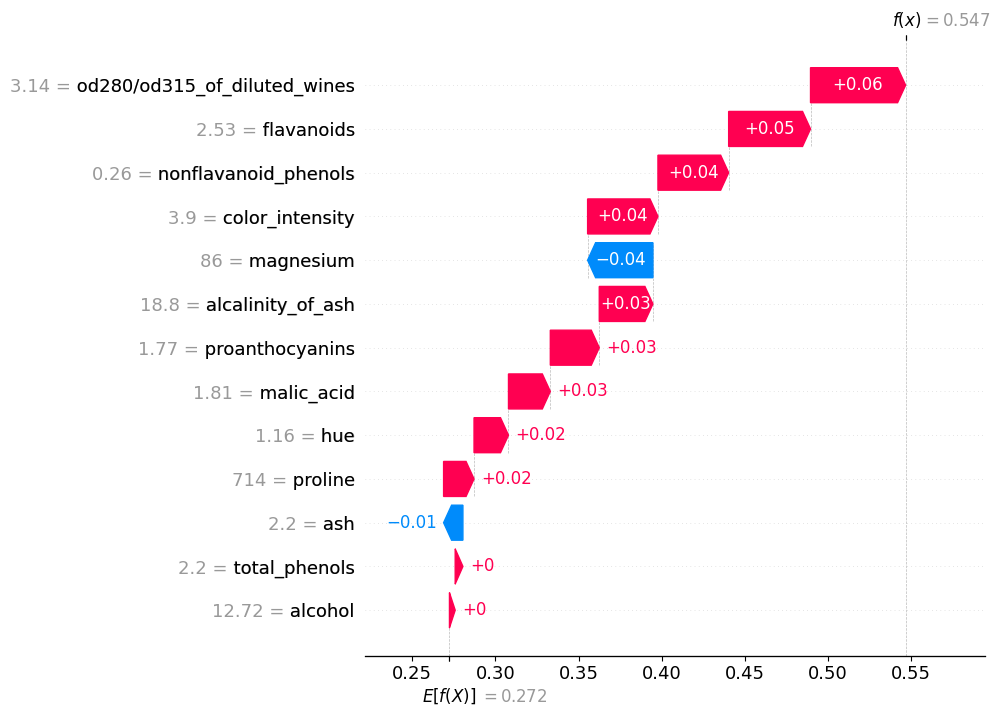

In [116]:
ax = shap.plots.waterfall(shap_values[fraud_index], max_display=13, show=True)

Apparently, for this inauthentic sample the values of od280, nonflavanoid_phenols, and flavanoids are very much like class 0 so the model seems to think this is class 0.  What about in margin space?

In [117]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)
background = shap.maskers.Partition(X_train_df, max_samples=1000, clustering=linkage)
explainer = shap.Explainer(compliant.decision_function, background, algorithm="exact")
shap_values = explainer(X_train_df)

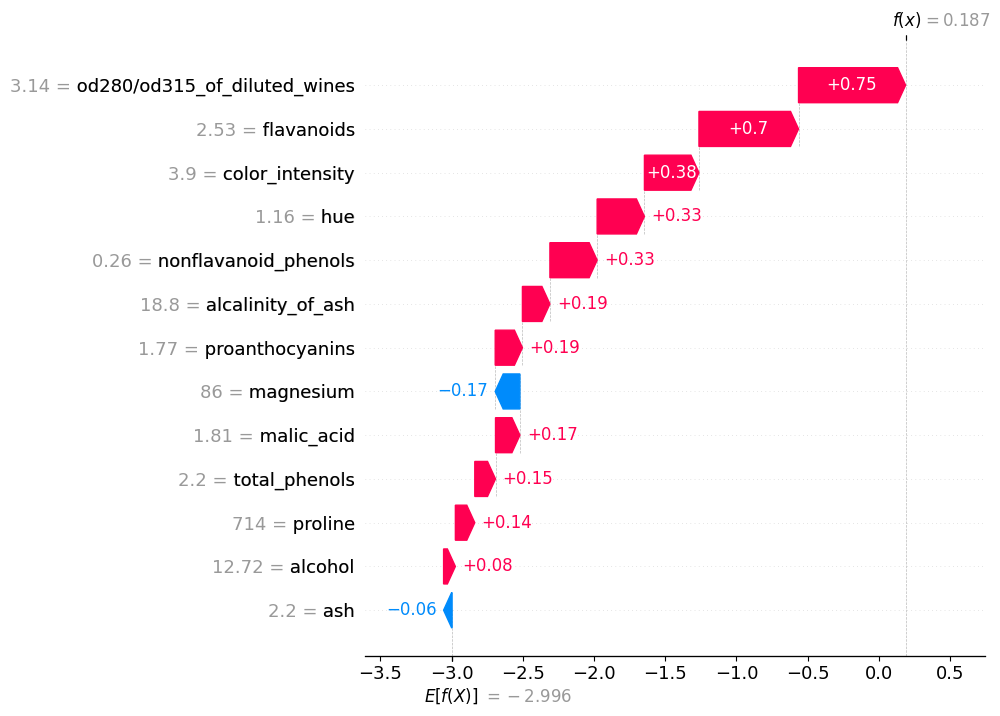

In [118]:
# Clearly the explanation is a little different, but overall the od280 and flavanoids are playing a big role.
ax = shap.plots.waterfall(shap_values[fraud_index], max_display=13, show=True)

<h3>Individual Conditional Explanations (ICE)</h3>

PDPs average out effects over all samples. However, as with SHAP decision plots, it can be helpful to display all individual predictions to identify patterns and heterogeneous behavior. PDPs are just the average of ICE plots.

> "If there are too many lines in an ICE plot, it can be difficult to see differences between individual samples and interpret the model. Centering the ICE at the first value on the x-axis, produces [centered Individual Conditional Expectation (cICE) plots](https://arxiv.org/abs/1309.6392). This puts emphasis on the divergence of individual conditional expectations from the mean line, thus making it easier to explore heterogeneous relationships. cICE plots can be plotted by setting centered=True."

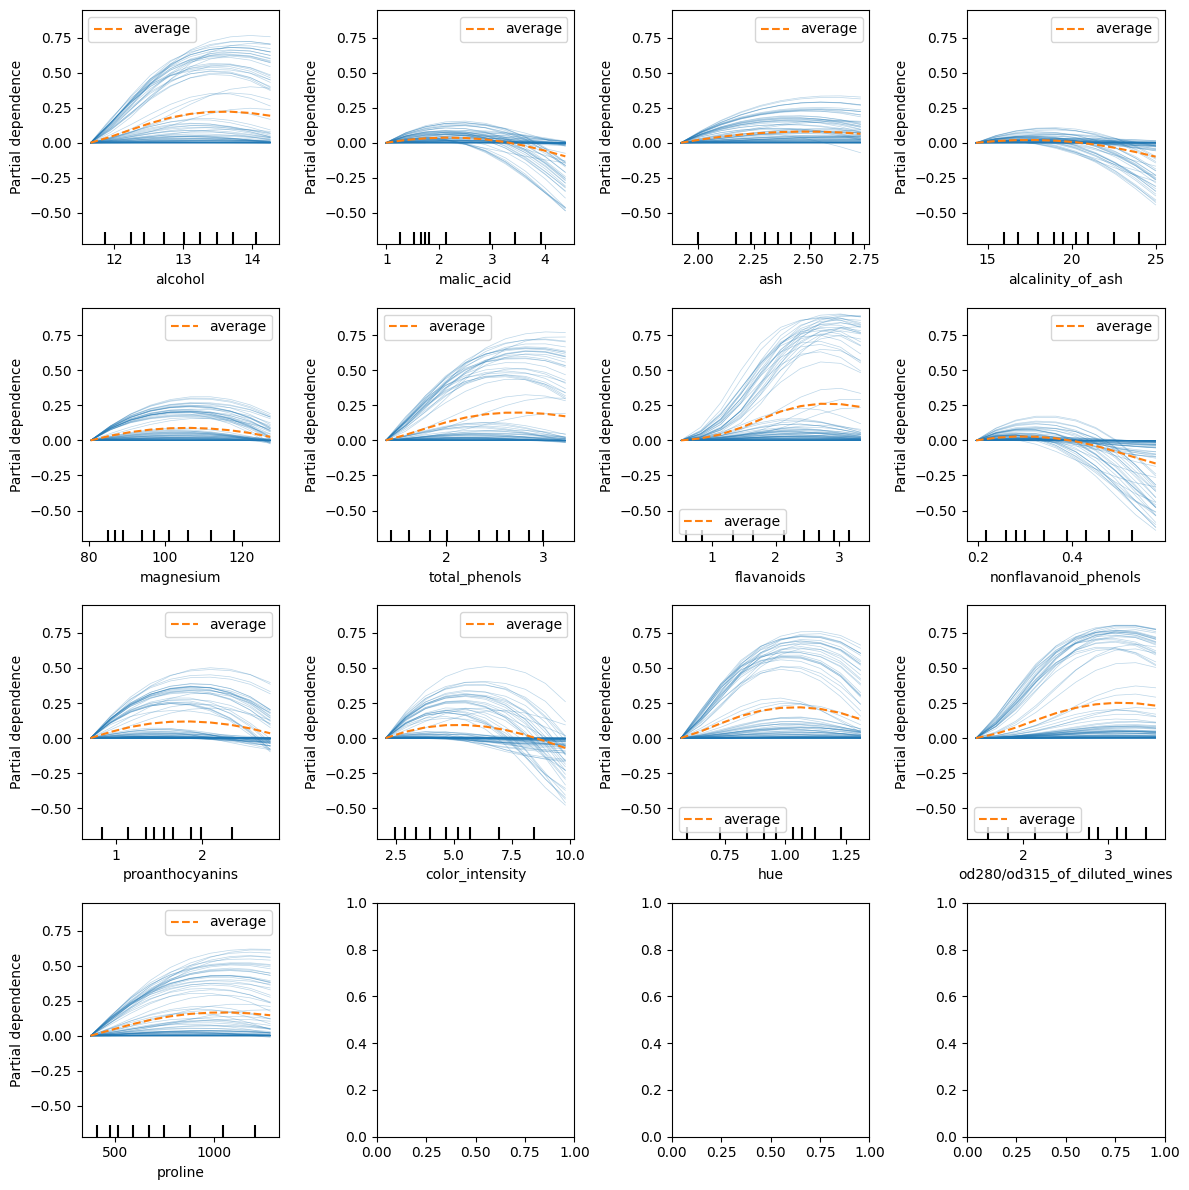

In [119]:
# In probability space
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))

_ = PartialDependenceDisplay.from_estimator(
    compliant,
    X=pd.DataFrame(X_train, columns=X.columns), # Assumes independence so best to use decorrelated features
    features=X.columns,
    response_method='predict_proba', # Use the model's predict_proba() method to compute the response
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='both', # This gives both partial dependence (average) and individual lines
    random_state=0,
    centered=True,
    ax=axes.ravel()[:13]
)
plt.tight_layout()

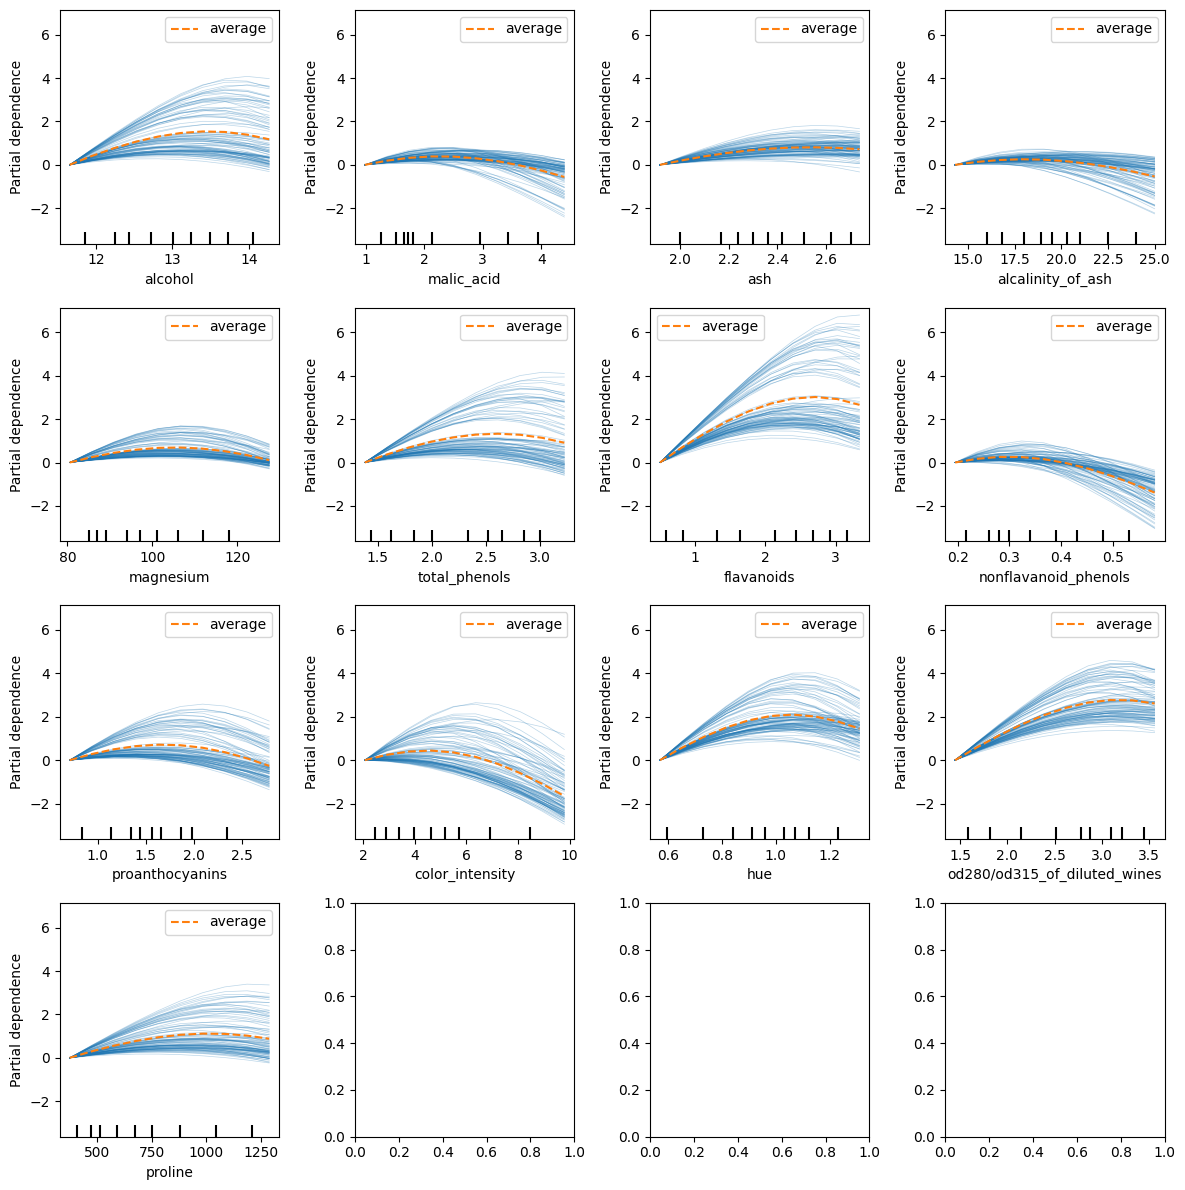

In [120]:
# In margin space
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))

_ = PartialDependenceDisplay.from_estimator(
    compliant,
    X=pd.DataFrame(X_train, columns=X.columns), # Assumes independence so best to use decorrelated features
    features=X.columns,
    response_method='decision_function', # Use the model's decision_function() method to compute the response
    method='brute',
    grid_resolution=10,
    subsample=100,
    kind='both', # This gives both partial dependence (average) and individual lines
    random_state=0,
    centered=True,
    ax=axes.ravel()[:13]
)
plt.tight_layout()